In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pyvis.network import Network
from pyvis.options import Layout
import networkx as nx

In [2]:
@dataclass
class Block:
    id: int
    t: float
    height: int
    parent: int
    leader: int

In [3]:
@dataclass
class NetworkParams:
    mixnet_delay_mean: int # seconds
    mixnet_delay_var: int
    broadcast_delay_mean: int # second
    pol_proof_time: int # seconds

    def sample_mixnet_delay(self):
        scale = self.mixnet_delay_var / self.mixnet_delay_mean
        shape = self.mixnet_delay_mean / scale
        return np.random.gamma(shape=shape, scale=scale)
    
    def sample_broadcast_delay(self, blocks):
        return np.random.exponential(self.broadcast_delay_mean, size=blocks.shape)

    def block_arrival_time(self, block_time):
        return self.pol_proof_time + self.sample_mixnet_delay() + self.sample_broadcast_delay(block_time) + block_time

In [4]:
@dataclass
class Params:
    CHAIN_HEIGHT: int
    MEAN_BLOCK_TIME: int
    honest_stake: np.array
    adversary_control: float

    @property
    def N(self):
        return len(self.stake)

    @property
    def stake(self):
        if self.adversary_control:
            adversary_stake = self.honest_stake.sum() / (1/self.adversary_control - 1)
            return np.append(self.honest_stake, adversary_stake)
        else:
            return self.honest_stake
    
    @property
    def relative_stake(self):
        return self.stake / self.stake.sum()

    def block_delay_at_height(self):
        return np.random.exponential(self.MEAN_BLOCK_TIME / self.relative_stake, size=(self.CHAIN_HEIGHT, self.N))

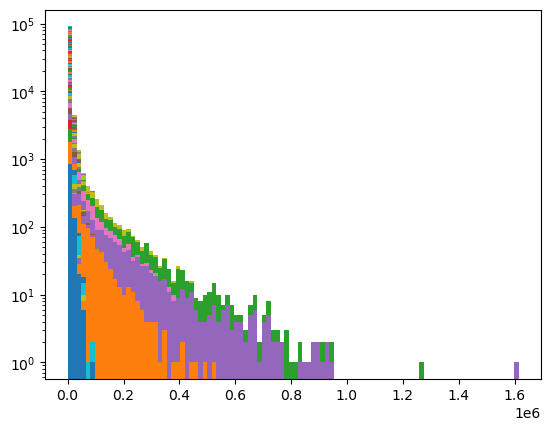

In [5]:
params = Params(
    CHAIN_HEIGHT=1000,
    MEAN_BLOCK_TIME=20,
    honest_stake = np.random.pareto(10, size=100),
    adversary_control=None,
)

_ = plt.hist(params.block_delay_at_height(), stacked=True, bins=100)
_ = plt.yscale("log")

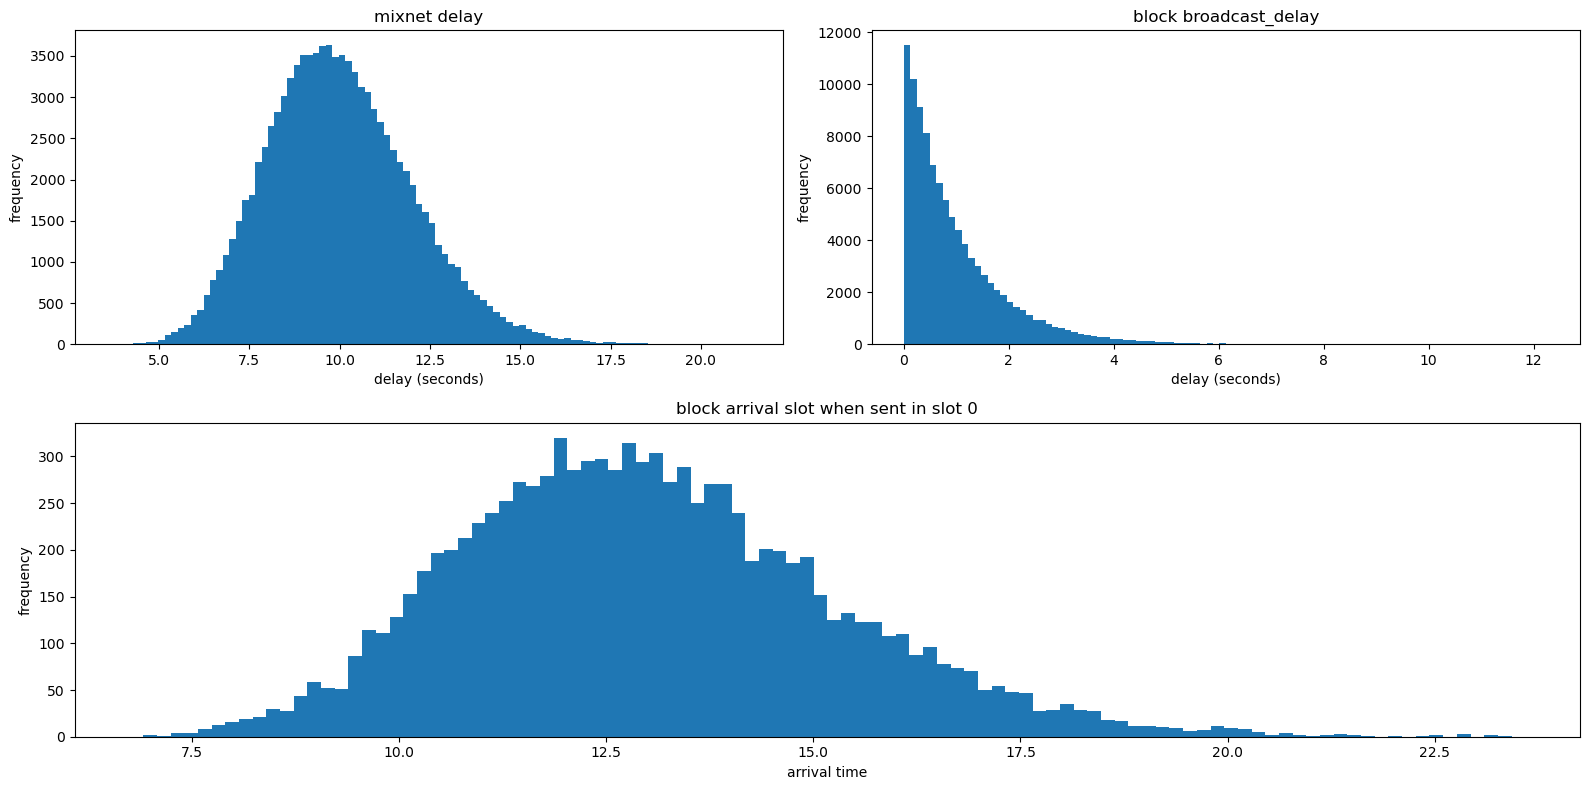

In [6]:
network = NetworkParams(
    mixnet_delay_mean=10, # seconds
    mixnet_delay_var=4,
    broadcast_delay_mean=1, # second
    pol_proof_time=2, # seconds
)


mixnet_delay_data = np.array([network.sample_mixnet_delay() for _ in range(100000)])

plt.figure(figsize=(16,8))
ax = plt.subplot(221)
_ = ax.hist(mixnet_delay_data, bins=100)
ax.set_title(f"mixnet delay")
_ = ax.set_ylabel("frequency")
_ = ax.set_xlabel("delay (seconds)")

broadcast_delay_data = network.sample_broadcast_delay(np.zeros(100000))
ax = plt.subplot(222)
_ = ax.hist(broadcast_delay_data, bins=100)
ax.set_title(f"block broadcast_delay")
ax.set_ylabel("frequency")
ax.set_xlabel("delay (seconds)")

BLOCK_TIME = 0
block_arrival_slots = np.array([network.block_arrival_time(np.array([BLOCK_TIME])) for _ in range(10000)])

ax = plt.subplot(212)
_ = ax.hist(block_arrival_slots, bins=100)
ax.set_title(f"block arrival slot when sent in slot {BLOCK_TIME}")
ax.set_ylabel("frequency")
ax.set_xlabel("arrival time")

plt.tight_layout()

In [15]:
class Sim:
    def __init__(self, params: Params, network: NetworkParams):
        self.params = params
        self.network = network
        self.events = {}
        self.blocks = []
        self.block_heights = np.array([], dtype=np.int64)
        self.block_arrivals = np.zeros(shape=(params.N, 0), dtype=np.int64) # arrival time to each leader for each block

    def emit_block(self, t, leader, height, parent):
        assert type(t) in [float, np.float64], type(t)
        assert type(leader) in [int, np.int64]
        assert type(height) in [int, np.int64]
        assert type(parent) in [int, np.int64]
    
        block = Block(
            id=len(self.blocks),
            t=t,
            height=height,
            parent=parent,
            leader=leader
        )
        self.blocks.append(block)
        self.block_heights = np.append(self.block_heights, block.height)
    
        # decide when this block will arrive at each node
        self.block_arrivals = np.append(self.block_arrivals, self.network.block_arrival_time(np.repeat(t, self.params.N).reshape((self.params.N, 1))), axis=1)
        return block.id

    def plot_spacetime_diagram(self, MAX_T=1 * 60 * 60):
        alpha_index = sorted(range(self.params.N), key=lambda n: self.params.relative_stake[n])
        nodes = [f"$N_{n}$($\\alpha$={self.params.relative_stake[n]:.2f})" for n in alpha_index]
        messages = [(nodes[alpha_index.index(self.blocks[b].leader)], nodes[alpha_index.index(node)], self.blocks[b].t, arrival_t, f"$B_{{{b}}}$") for b, arrival_ts in enumerate(self.block_arrivals.T) for node, arrival_t in enumerate(arrival_ts) if arrival_t < MAX_T]
        
        fig, ax = plt.subplots(figsize=(8,8))
        
        # Plot vertical lines for each node
        max_slot = max(s for _,_,start_t, end_t,_ in messages for s in [start_t, end_t])
        for i, node in enumerate(nodes):
            ax.plot([i, i], [0, max_slot], 'k-', linewidth=0.1)
            ax.text(i, max_slot + 30 * (0 if i % 2 == 0 else 1), node, ha='center', va='bottom')
        
        # Plot messages
        colors = plt.cm.rainbow(np.linspace(0, 1, len(messages)))
        for (start, end, start_time, end_time, label), color in zip(messages, colors):
            start_idx = nodes.index(start)
            end_idx = nodes.index(end)
            ax.annotate('', xy=(end_idx, end_time), xytext=(start_idx, start_time),
                        arrowprops=dict(arrowstyle='->', color="black", lw=0.5))
            placement = 0
            mid_x = start_idx * (1 - placement) + end_idx * placement
            mid_y = start_time * (1 - placement) + end_time * placement
            ax.text(mid_x, mid_y, label, ha='center', va='center', 
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        ax.set_xlim(-1, len(nodes))
        ax.set_ylim(0, max_slot + 70)
        ax.set_xticks(range(len(nodes)))
        ax.set_xticklabels([])
        # ax.set_yticks([])
        ax.set_title('Space-Time Diagram')
        ax.set_ylabel('Time')
        
        plt.tight_layout()
        plt.show()

    def honest_chain(self):
        chain_head = max(self.blocks, key=lambda b: b.height)
        honest_chain = {chain_head.id}
        
        curr_block = chain_head
        while curr_block.parent >= 0:
            honest_chain.add(curr_block.parent)
            curr_block = self.blocks[curr_block.parent]
        return sorted(honest_chain, key=lambda b: self.blocks[b].height)

    def visualize_chain(self):
        honest_chain = self.honest_chain()
        print("Honest chain length", len(honest_chain))
        honest_chain_set = set(honest_chain)
        
        layout = Layout()
        layout.hierachical = True
        
        G = Network(width=1600, height=800, notebook=True, directed=True, layout=layout, cdn_resources='in_line')

        for block in self.blocks:
            # level = slot
            level = block.height
            color = "lightgrey"
            if block.id in honest_chain_set:
                color = "orange"

            G.add_node(int(block.id), level=block.height, color=color, label=f"{block.t:.2f}")
            # G.add_node(int(block.id), level=block.t * 0.1, color=color, label=f"{block.height}")

            if block.parent >= 0:
                G.add_edge(int(block.id), int(block.parent), width=2, color=color)
        
        return G.show("chain.html")

    def adverserial_analysis(self):
        np.random.seed(0)
        adversary = self.params.N - 1
        
        reorg_depths = []
        honest_chain = self.honest_chain()
        print("honest_chain length", len(honest_chain))

        adversary_delays = self.delays.T[adversary]

        for block in self.blocks:
            if block.id % 100 == 0:
                print("processing", block)
            nearest_honest_block = block
            while nearest_honest_block.height >= len(honest_chain) or honest_chain[nearest_honest_block.height-1] != nearest_honest_block.id:
                nearest_honest_block = self.blocks[nearest_honest_block.parent]
        
            
            adversary_blocks = []
            t = block.t
            for h in range(block.height + 1, self.params.CHAIN_HEIGHT):
                t += adversary_delays[h-1]
                adversary_blocks.append(t)
                adverserial_height = block.height + len(adversary_blocks)
                
                honest_chain_up_to_t = [
                    b for b in honest_chain
                    if self.blocks[b].t <= t
                ]
                last_honest_block = self.blocks[honest_chain_up_to_t[-1]]
                assert last_honest_block.height >= nearest_honest_block.height, (t, last_honest_block, nearest_honest_block)
                if last_honest_block.height < adverserial_height:
                    reorg_depths += [last_honest_block.height - nearest_honest_block.height]
        
        plt.hist(reorg_depths, bins=60)
        plt.grid(True)
        plt.title(f"reorg depths with {self.params.adversary_control * 100:.0f}% adversary")
        plt.show()

    def run(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

        
        # emit the genesis block
                
        
        t = 0.0
        self.emit_block(
            t=t,
            leader=0,
            height=1,
            parent=-1,
        )
        self.block_arrivals[:,:] = 0 # all nodes see the genesis block immediately
        
        self.delays = self.params.block_delay_at_height()

        for h in range(1, self.params.CHAIN_HEIGHT):
            for leader, block_delay in enumerate(self.delays[h-1]):
                if self.params.adversary_control and leader == self.params.N-1:
                    continue
                leader_arrivals = self.block_arrivals[leader]
                
                parent = (leader_arrivals == leader_arrivals[self.block_heights == h].min()).argmax()
                assert parent is not None
                assert self.blocks[parent].height == h, (self.blocks[parent], h)
                self.emit_block(
                    t=self.blocks[parent].t + block_delay,
                    leader=leader,
                    height=self.blocks[parent].height + 1,
                    parent=parent,
                )

In [16]:
np.random.seed(0)

sim = Sim(
    params=Params(
        CHAIN_HEIGHT=245,
        MEAN_BLOCK_TIME=20,
        honest_stake = np.random.pareto(10, size=10),
        adversary_control=0.3,
    ),
    network=NetworkParams(
        mixnet_delay_mean=10, # seconds
        mixnet_delay_var=4,
        broadcast_delay_mean=2, # second
        pol_proof_time=2, # seconds
    )
)
sim.run(seed=5)
# sim.visualize_chain()
# sim.plot_spacetime_diagram()

n_blocks_per_s = len(sim.blocks) / max(b.t for b in sim.blocks)
print("avg blocks per sec", n_blocks_per_s)
print("Number of blocks", len(sim.blocks))
print("longest chain", max(b.height for b in sim.blocks))

avg blocks per sec 0.21317693308797184
Number of blocks 2441
longest chain 245


honest_chain length 245
processing Block(id=0, t=0.0, height=1, parent=-1, leader=0)
processing Block(id=100, t=1231.1825397618154, height=11, parent=81, leader=9)
processing Block(id=200, t=643.888657267845, height=21, parent=189, leader=9)
processing Block(id=300, t=2018.0763488312223, height=31, parent=286, leader=9)
processing Block(id=400, t=1652.7268466796731, height=41, parent=390, leader=9)
processing Block(id=500, t=2166.111823344706, height=51, parent=483, leader=9)
processing Block(id=600, t=2309.4070586513462, height=61, parent=588, leader=9)
processing Block(id=700, t=1975.9198897321473, height=71, parent=689, leader=9)
processing Block(id=800, t=2166.04768532737, height=81, parent=787, leader=9)
processing Block(id=900, t=2480.0230869739353, height=91, parent=882, leader=9)
processing Block(id=1000, t=4488.3970031230565, height=101, parent=986, leader=9)
processing Block(id=1100, t=3511.4998241967496, height=111, parent=1083, leader=9)
processing Block(id=1200, t=5101.306

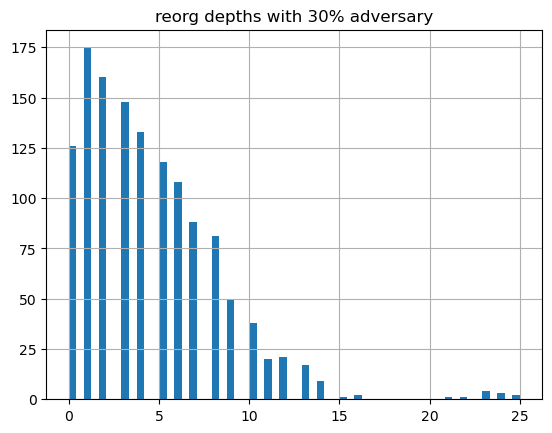

In [17]:
sim.adverserial_analysis()

Text(0.5, 0, 'PoL time as fraction of mean block time')

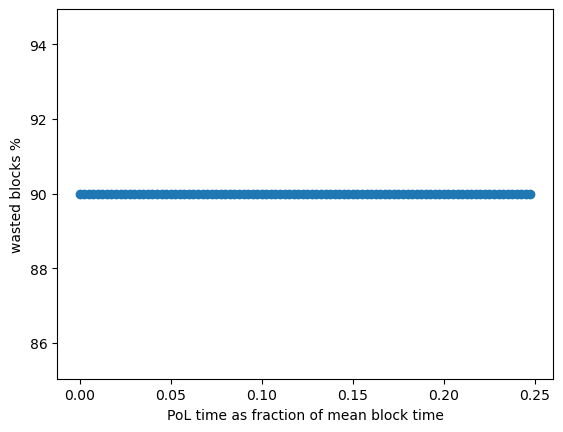

In [18]:
N = 100
net_params = [NetworkParams(
        mixnet_delay_mean=0.1, # seconds
        mixnet_delay_var=0.1,
        broadcast_delay_mean=0.1, # second
        pol_proof_time=i/N * 5, # seconds
    ) for i in range(N)]

sims = [Sim(
    params=Params(
        CHAIN_HEIGHT=1000, # seconds
        MEAN_BLOCK_TIME=20,
        honest_stake = np.random.pareto(10, size=10),
        adversary_control=0.1,
    ),
    network=net
) for net in net_params]

[sim.run() for sim in sims]


plt.scatter([sim.network.pol_proof_time / sim.params.MEAN_BLOCK_TIME for sim in sims], [100 - 100 * len(sim.honest_chain()) / len(sim.blocks) for sim in sims])
plt.ylabel("wasted blocks %")
plt.xlabel("PoL time as fraction of mean block time")